In [16]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import scipy.io
import os
import shutil
from PIL import Image
import random
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import time

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow import keras

In [2]:
def topic_feature_extraction(topic):
    #Outputs:
    #img_names: vector con los nombres de las imagenes (sin .jpg) segun el orden inicial
    #img_features: vector con las caracteristicas visuales segun el orden inicial
    #img_names_ranked: vector con los nombres de las imagenes ordenados de mayor a menor probabilidad textual
    #img_st: vector con las probabilidades textuales ordenadas de mayor a menor (alineado con img_names)
    #reorder_st: vector con las posiciones de img_names ordenadas de mayor a menor probabilidad
    
    
    descr_path = r"D:\MediaEval2016\Dades\descriptores"
    descr_mat = scipy.io.loadmat(os.path.join(descr_path,f"topic{topic}"))
    
    img_names = []
    img_features = []
    img_names_ranked = []
    img_st = []
    
    for i in range(len(descr_mat["names"])):
        img_names.append(str(descr_mat["names"][i][0][0][0])) #No esta ordenado por st
        img_features.append(descr_mat["datosImagenes"][i][2:]) #No esta ordenado por st        
        img_names_ranked.append(str(int(descr_mat["st"][i][0][0][0]))) #Nombres ordenados por st
        img_st.append(descr_mat["st"][i][2][0][0]) #Probabilidad ordenadas por st de mayor a menor
        
    reorder_st = []
    for img in img_names_ranked:
        reorder_st.append(img_names.index(img))
        
    img_features_ranked = []
    for pos in reorder_st:
        img_features_ranked.append(img_features[pos])
    
    img_features_ranked_list = []
    for array in img_features_ranked:
        aux=[]
        for i in range(array.shape[0]):
            aux.append(array[i][0][0])
        img_features_ranked_list.append(np.array(aux))
    
    
    return img_features_ranked_list,img_names_ranked

In [3]:
def creation_training_set_Descriptores(topic,tipo,num_cluster): 
    
    #Input:  número entero representa el topic
    #Output: X_train lista de tensores de tamaño (15) con dimensiones (3,224,224)
    #        y_train lista de 1 y 0 representando si son positivas o negativas
    
    topic_str = "topic"+str(topic)

    directorio = r'D:\MediaEval2016\Dades\images'
    if tipo==1:
        dir_pos = os.path.join(directorio,"positivas","5primeras_st_no_diversity"+f"_{num_cluster}",topic_str)
        dir_neg = os.path.join(directorio,"neg",topic_str)
    elif tipo==2:
        dir_pos = os.path.join(directorio,"positivas","5primeras_st_ClusterVisual"+f"_{num_cluster}",topic_str)
        dir_neg = os.path.join(directorio,"neg",topic_str)
    elif tipo==3:
        dir_pos = os.path.join(directorio,"positivas","5primeras_Flickr_no_diversity"+f"_{num_cluster}",topic_str)
        dir_neg = os.path.join(directorio,"neg",topic_str)
    elif tipo==4:
        dir_pos = os.path.join(directorio,"positivas","5primeras_Flickr_ClusterVisual"+f"_{num_cluster}",topic_str)
        dir_neg = os.path.join(directorio,"neg",topic_str)
     
    #Extraigo los descriptores de las imagenes ordenados por score textual
    features_ranked,img_ranked = topic_feature_extraction(topic)
    
    
    #Juntamos las imagenes positivas y negativas en un conjunto de entrenamiento
    X_train_pos = []
    y_train_pos = []
    X_train_neg = []
    y_train_neg = []
        
    for file in os.listdir(dir_pos):
        img_name = file.replace(".jpg","")
        posicion_positiva_en_ranked = img_ranked.index(img_name)
        X_train_pos.append(features_ranked[posicion_positiva_en_ranked])
        y_train_pos.append(1)
        
    #print(X_train_pos)
    
    #Tengo que localizar el nombre de las imagenes negativas en su topic para poder abrir sus descriptores.
    
    for file in os.listdir(dir_neg):
        #Extraemos del nombre de la imagen: "negative_from_12.jpg" el topic 12
        topic_neg = int(file.replace(".jpg","").replace("negative_from_",""))
        #Abrimos los descriptores del topic 12
        negative_features,imgs_topic_negatives = topic_feature_extraction(topic_neg)
        #Conseguimos el nombre de la imagen negativa y le quitamos el .jpg con :-4
        img_negative_name = os.listdir(os.path.join(directorio,"collection",f"topic{topic_neg}"))[0][:-4]
        #Hemos de encontrar el indice de ese nombre en el score textual para conseguir sus descriptores
        posicion_negativa_en_ranked = imgs_topic_negatives.index(img_negative_name)
        #Extraemos los descriptores de la imagen negativa
        X_train_neg.append(negative_features[posicion_negativa_en_ranked])
        y_train_neg.append(0)
        

    X_train = X_train_pos+X_train_neg
    y_train = y_train_pos+y_train_neg
    
    return X_train,y_train

In [4]:
def creation_negatives(topic,n,tipo=1):
    #Tipo 1: primera imagen de los 10 siguientes topics
    
    
    directorio = r'D:\MediaEval2016\Dades\images'
    
    if tipo == 1:
        if "neg" in os.listdir(directorio):
            pass
        else:
            os.mkdir(os.path.join(directorio,"neg"))
        
        neg_path = os.path.join(directorio,"neg")
        
        if f"topic{topic}" in os.listdir(neg_path):
            shutil.rmtree(os.path.join(neg_path,f"topic{topic}"))
            os.mkdir(os.path.join(neg_path,f"topic{topic}"))
        else:
            os.mkdir(os.path.join(neg_path,f"topic{topic}"))
            
        topic_path = os.path.join(neg_path,f"topic{topic}")
        
        for next_topics in random.sample([x for x in range(1,136) if (x != topic and x!= 124)],10):
            next_topic_folder = os.path.join(directorio,"collection",f"topic{next_topics}")
            next_topic_img = os.listdir(next_topic_folder)[0]

            img = Image.open(os.path.join(next_topic_folder,next_topic_img))
            img.save(os.path.join(topic_path,f"negative_from_{next_topics}.jpg"))
                
    else:
        print("No implementado")

In [5]:
def clustering_visual(topic,numero_clusters):
    features,img_ranked = topic_feature_extraction(topic)
    #El algoritmo KMeans necesita entrenar sobre una matriz X de features. Como features es actualmente una lista de array
    #de dimensiones (50,), hemos de convertirlo a un array 300x50
    
    kmeans=KMeans(n_clusters=numero_clusters,n_init=20).fit(np.array(features))
    #centroids_array = kmeans.cluster_centers_ #Vector num_cluster x 50,
    visual_cluster_ranked_array = kmeans.labels_ #Vector que asocia a cada imagen su cluster visual. Esta ordenado por st
    
    return img_ranked,visual_cluster_ranked_array

In [6]:
def creation_positives(topic,n,tipo,numero_clusters):
    #Tipo 1: 5 primeras por score textual sin diversidad
    #Tipo 2: 5 primeras por score textual con diversidad de clusters visuales
    #Tipo 3: 5 primeras por score textual con diversidad de clusters textuales
    #Tipo 4: 5 primeras Flicker
    #Tipo 5: 5 primeras Flicker con diversidad de clusters visuales
    
    directorio = r'D:\MediaEval2016\Dades\images'
    if "positivas" in os.listdir(directorio):
        pass
    else:
        os.mkdir(os.path.join(directorio,"positivas"))
    
    
    if tipo==1:
        
        if "5primeras_st_no_diversity" in os.listdir(os.path.join(directorio,"positivas")):
            pass
        else:
            os.mkdir(os.path.join(directorio,"positivas","5primeras_st_no_diversity"))
            
        #Definimos 'D:\MediaEval2016\Dades\images\pos'
        pos_path = os.path.join(directorio,"positivas","5primeras_st_no_diversity")
        
        if f"topic{topic}" in os.listdir(pos_path):
            shutil.rmtree(os.path.join(pos_path,f"topic{topic}"))
            time.sleep(.0000001)
            os.mkdir(os.path.join(pos_path,f"topic{topic}"))
        else:
            os.mkdir(os.path.join(pos_path,f"topic{topic}"))
        
        #Definimos 'D:\MediaEval2016\Dades\images\pos\topic1'
        topic_pos_path = os.path.join(pos_path,f"topic{topic}")
        
        #Definimos 'D:\MediaEval2016\Dades\images\collection\topic1'
        topic_path_folder = os.path.join(directorio,"collection",f"topic{topic}")    

        _,img_ranked = topic_feature_extraction(topic)
        first_n_img_names = img_ranked[:n]
        
        
        for img_name in first_n_img_names:
            img = Image.open(os.path.join(topic_path_folder,img_name+".jpg"))
            img.save(os.path.join(topic_pos_path,img_name+".jpg"))
    
    
    elif tipo==2:
        
        if "5primeras_st_ClusterVisual" in os.listdir(os.path.join(directorio,"positivas")):
            pass
        else:
            os.mkdir(os.path.join(directorio,"positivas","5primeras_st_ClusterVisual"))
            
        #Definimos 'D:\MediaEval2016\Dades\images\pos'
        pos_path = os.path.join(directorio,"positivas","5primeras_st_ClusterVisual")
        
        if f"topic{topic}" in os.listdir(pos_path):
            shutil.rmtree(os.path.join(pos_path,f"topic{topic}"))
            time.sleep(.0000001)
            os.mkdir(os.path.join(pos_path,f"topic{topic}"))
        else:
            os.mkdir(os.path.join(pos_path,f"topic{topic}"))
            
            
        #Definimos 'D:\MediaEval2016\Dades\images\pos\topic1'
        topic_pos_path = os.path.join(pos_path,f"topic{topic}")
        
        #Definimos 'D:\MediaEval2016\Dades\images\collection\topic1'
        topic_path_folder = os.path.join(directorio,"collection",f"topic{topic}")
        
        
           
        img_ranked,visual_cluster_ranked = clustering_visual(topic,numero_clusters)
        
        #Procedemos a realizar lo siguiente. 
        #1. Seleccionamos la primera imagen de ranking textual
        #2. Comprobamos a que cluster visual pertenece.
        #3. Si el cluster tiene menos de 5 imágenes, no seleccionamos esa imagen y pasamos a la siguiente
        #4. Si el cluster tiene 5 o más imágenes, esa imagen entra como positiva.
        #5. Se añade un 1 a un vector de cluster para indicar que no pueden entrar más imágenes de ese cluster a las positivas
        
        cluster_bool = np.zeros(numero_clusters) #Hay clusters del 0 al numero_clusters-1
        
        positivas_seleccionadas = 0
        imagenes_comprobadas = 0
        
        for index, imagen in enumerate(img_ranked):
            
            #Selecciono el cluster al que pertenece la imagen "imagen" que es la primera del ranking st
            cluster_imagen = visual_cluster_ranked[index]
            
            if cluster_bool[cluster_imagen]==0: #Si no hemos seleccionado ninguna imagen de ese cluster
                
                #Calculo el número total de imágenes que pertenecen al cluster de la imagen "imagen"
                total_imagenes_cluster = np.argwhere(visual_cluster_ranked==cluster_imagen).shape[0]

                if total_imagenes_cluster>=5:  #Si el cluster contiene 5 o más imágenes
                    
                    #Abrimos la imagen que se encuentra en la carpeta collection/topic
                    img = Image.open(os.path.join(topic_path_folder,imagen+".jpg"))
                    #Guardamos la imagen en la carpeta de las positivas
                    img.save(os.path.join(topic_pos_path,imagen+".jpg"))
                    
                    positivas_seleccionadas+=1
                    cluster_bool[cluster_imagen] = 1

                elif total_imagenes_cluster<5:  #Si el cluster no contiene 5 o más imágenes
                    cluster_bool[cluster_imagen] = 1 #Marco con un 1 que ese cluster no nos sirve al tener pocas imágenes
            
            elif cluster_bool[cluster_imagen]==1: #Si el cluster de la imagen ya está seleccionado
                imagenes_comprobadas+=1
            
            #Si ya tenemos las n positivas
            if positivas_seleccionadas == n: 
                break

                    
    elif tipo==3:
        if "5primeras_Flickr_no_diversity" in os.listdir(os.path.join(directorio,"positivas")):
                pass
        else:
            os.mkdir(os.path.join(directorio,"positivas","5primeras_Flickr_no_diversity"))

        #Definimos 'D:\MediaEval2016\Dades\images\pos'
        pos_path = os.path.join(directorio,"positivas","5primeras_Flickr_no_diversity")

        if f"topic{topic}" in os.listdir(pos_path):
            shutil.rmtree(os.path.join(pos_path,f"topic{topic}"))
            time.sleep(.0000001)
            os.mkdir(os.path.join(pos_path,f"topic{topic}"))
        else:
            os.mkdir(os.path.join(pos_path,f"topic{topic}"))

        #Definimos 'D:\MediaEval2016\Dades\images\pos\topic1'
        topic_pos_path = os.path.join(pos_path,f"topic{topic}")

        #Definimos 'D:\MediaEval2016\Dades\images\collection\topic1'
        topic_path_folder = os.path.join(directorio,"collection",f"topic{topic}")    
            
        first_n_img_names = os.listdir(topic_path_folder)[:n]


        for img_name in first_n_img_names:
            img = Image.open(os.path.join(topic_path_folder,img_name))
            img.save(os.path.join(topic_pos_path,img_name))
            
    elif tipo==4:
        
        if "5primeras_Flickr_ClusterVisual" in os.listdir(os.path.join(directorio,"positivas")):
            pass
        else:
            os.mkdir(os.path.join(directorio,"positivas","5primeras_Flickr_ClusterVisual"))
            
        #Definimos 'D:\MediaEval2016\Dades\images\pos'
        pos_path = os.path.join(directorio,"positivas","5primeras_Flickr_ClusterVisual")
        
        if f"topic{topic}" in os.listdir(pos_path):
            shutil.rmtree(os.path.join(pos_path,f"topic{topic}"))
            time.sleep(.0000001)
            os.mkdir(os.path.join(pos_path,f"topic{topic}"))
        else:
            os.mkdir(os.path.join(pos_path,f"topic{topic}"))
            
            
        #Definimos 'D:\MediaEval2016\Dades\images\pos\topic1'
        topic_pos_path = os.path.join(pos_path,f"topic{topic}")
        
        #Definimos 'D:\MediaEval2016\Dades\images\collection\topic1'
        topic_path_folder = os.path.join(directorio,"collection",f"topic{topic}")
        
        
        #Obtenemos el vector de clusters visuales ordenados por score textual
        img_ranked,visual_cluster_ranked = clustering_visual(topic,numero_clusters)
        
        img_Flickr = []
        for img in os.listdir(topic_path_folder):
            img_Flickr.append(img.replace(".jpg",""))
        #Debemos localizar las imagenes de FLickr en el ranking textual y seleccionar el cluster
        
        visual_cluster_Flickr = []       
        for img in img_Flickr:
            visual_cluster_Flickr.append(visual_cluster_ranked[img_ranked.index(img)])
        
        visual_cluster_Flickr = np.array(visual_cluster_Flickr)
        
        #Procedemos a realizar lo siguiente. 
        #1. Seleccionamos la primera imagen de ranking textual
        #2. Comprobamos a que cluster visual pertenece.
        #3. Si el cluster tiene menos de 5 imágenes, no seleccionamos esa imagen y pasamos a la siguiente
        #4. Si el cluster tiene 5 o más imágenes, esa imagen entra como positiva.
        #5. Se añade un 1 a un vector de cluster para indicar que no pueden entrar más imágenes de ese cluster a las positivas
        
        cluster_bool = np.zeros(numero_clusters) #Hay clusters del 0 al numero_clusters-1
        
        positivas_seleccionadas = 0
        imagenes_comprobadas = 0
        
        for index, imagen in enumerate(img_Flickr):
            
            #Selecciono el cluster al que pertenece la imagen "imagen" que es la primera del ranking st
            cluster_imagen = visual_cluster_Flickr[index]
            
            if cluster_bool[cluster_imagen]==0: #Si no hemos seleccionado ninguna imagen de ese cluster
                
                #Calculo el número total de imágenes que pertenecen al cluster de la imagen "imagen"
                total_imagenes_cluster = np.argwhere(visual_cluster_Flickr==cluster_imagen).shape[0]

                if total_imagenes_cluster>=5:  #Si el cluster contiene 5 o más imágenes
                    
                    #Abrimos la imagen que se encuentra en la carpeta collection/topic
                    img = Image.open(os.path.join(topic_path_folder,imagen+".jpg"))
                    #Guardamos la imagen en la carpeta de las positivas
                    img.save(os.path.join(topic_pos_path,imagen+".jpg"))
                    
                    positivas_seleccionadas+=1
                    cluster_bool[cluster_imagen] = 1

                elif total_imagenes_cluster<5:  #Si el cluster no contiene 5 o más imágenes
                    cluster_bool[cluster_imagen] = 1 #Marco con un 1 que ese cluster no nos sirve al tener pocas imágenes
            
            elif cluster_bool[cluster_imagen]==1: #Si el cluster de la imagen ya está seleccionado
                imagenes_comprobadas+=1
            
            #Si ya tenemos las n positivas
            if positivas_seleccionadas == n: 
                break

In [7]:
def creation_test_set(topic):
    #Creamos el testset con las 300 imágenes del topic
    directorio = r'D:\MediaEval2016\Dades\images'
    
    X_test = []
    img_names_fold_order = []
    path_test = os.path.join(directorio,"collection",f"topic{topic}")
    for file in os.listdir(path_test):
        
        file_no_jpg = file.replace(".jpg","")
        img_names_fold_order.append(file_no_jpg)
        #Localizamos la imagen en el score textual para conseguir sus descriptores
        features_ranked,img_ranked = topic_feature_extraction(topic)
        posicion_img_en_ranked = img_ranked.index(file_no_jpg)
        X_test.append(features_ranked[posicion_img_en_ranked])
        
        
    return X_test, img_names_fold_order

In [8]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [15]:
def results_file_creation(topic,algoritmo,seleccion_positivas):
    path = r"D:\MediaEval2016\Dades\resultados"
    team = "UNED_UV"
    if algoritmo == 1:
        run = "run1"
    elif algoritmo == 3:
        run = "run3"
    elif algoritmo == 5:
        run = "run5"

    if seleccion_positivas == 1:
        positivas = "5primeras_Flicker"
    elif seleccion_positivas == 2:
        positivas = "ClustersVisuales_20"
    
    tipo = 'ini_' + str(topic)
    name = run + "_" + team + "_" + tipo + "_" + positivas + "_LogisticRegression.txt"
    filename = os.path.join(path,name)
    
    if filename in os.listdir(path):
        os.remove(filename)
        
    fp = open(filename,"a")
    return fp

In [10]:
def get_text_clusters(topic):
    clustering_path = r"D:\MediaEval2016\Dades\clusterings"
    file_name = f"{topic}-{topic_2name(topic)}-Clusters.txt"
    file_path = os.path.join(clustering_path,file_name)
    text_clusters_df = pd.read_csv(file_path,sep="	",header=0,names=["Id_Imagen","Cluster"])
    return text_clusters_df

In [11]:
def reorder_ranking(topic,rank_names,rank_probs,ranking_algoritmo):
    
    #ranking_algoritmo: 1. Reordena por clusters visuales (run1)
    #                   2. Reordena por clusters textuales (run3)
    umbral = 0.2
    numero_clusters = 15
    if ranking_algoritmo == 1: 
        #Obtenemos un vector con los names de las imagenes ordenadas por st, al igual que el cluster al que pertenecen
        img_rank,visual_cluster_ranked = clustering_visual(topic,numero_clusters)
        
        #Objetivo: seleccionamos primera imagen del ranking visual, buscamos su cluster visual, 
        
        clusters_ranked_visual = []
        for index,img in enumerate(rank_names):
            posicion_visual_en_textual = img_rank.index(img)
            cluster = visual_cluster_ranked[posicion_visual_en_textual]
            clusters_ranked_visual.append(cluster)
        
        ranking_final = []
        candidatas = np.zeros(len(rank_names))
        while len(ranking_final)<50:
            imclusters = np.zeros(numero_clusters)
            for index,img in enumerate(rank_names):
                
                #Si en esta iteración no hemos seleccionado imgs de ese cluster y esa imagen no está en el ranking final
                if imclusters[clusters_ranked_visual[index]]==0 and candidatas[index]==0 and rank_probs[index]>umbral:
                    ranking_final.append(img)
                    candidatas[index] = 1
                    imclusters[clusters_ranked_visual[index]] = 1
                    if len(ranking_final)==50:
                        break
                        
    elif ranking_algoritmo==3:
        #Abrimos el dataset que relaciona cada imagen con sus clusters textuales
        text_clusters_df = get_text_clusters(topic)
        numero_clusters = np.unique(text_clusters_df["Cluster"]).size
        
        imagenes_del_cluster = []
        probs_del_cluster = []
        #Almaceno en una lista, las imagenes que pertenecen a cada cluster dentro de otras listas y en otra las probabilidades
        for index,cluster in enumerate(np.unique(text_clusters_df["Cluster"])):
            imagenes_del_cluster.append((text_clusters_df[text_clusters_df["Cluster"]==cluster]["Id_Imagen"].to_list()))
            probs = []
            for img in imagenes_del_cluster[index]:
                posicion_img_en_visual = rank_names.index(str(img))
                probs.append(rank_probs[posicion_img_en_visual])
            probs_del_cluster.append(probs)

        #Calculo el vector que contiene las probabilidades más altas de cada cluster
        #Para ello, recorro todos los clusters y de cada uno busco sus probabilidades y selecciono la más alta
        probs_maxs = []
        id_probs_max = []
                
        for index,prob_cluster in enumerate(probs_del_cluster): #prob_cluster es la lista que contiene las probabilidades de las img de ese cluster
            probs_maxs.append(np.max(prob_cluster)) #Me guardo el valor de la probabilidad maxima de las imgs en un cluster
            img = imagenes_del_cluster[index][np.argmax(prob_cluster)]
            id_probs_max.append(img) #Me guardo el nombre de la imagen del cluster mas probable
                
        #Ahora tengo dos listas; una que contiene la imagen con la probabilidad maxima de cada cluster
        
        
        
        ranking_final = []
        continuar = True
        vueltas = 1
        while continuar:
            #Compruebo el numero de clusters que contienen al menos una imagen
            num_clusters_no_vacios = 0
            for cluster_imgs in imagenes_del_cluster:
                if len(cluster_imgs)>0:
                    num_clusters_no_vacios+=1
            #Generalmente, todos los clusters contienen alguna imagen
            i = 1
            seguir = 1
            while seguir:
                
                #Ahora calculo cual de entre las imagenes mas probables por cluster es la más probable,
                #y calculo además su posición, por lo que conoceremos el cluster (ya que cluster = posicion+1)
                maximo = np.max(probs_maxs)
                index = np.argmax(probs_maxs)
                imagen_max = id_probs_max[index]
                cluster_max = np.unique(text_clusters_df["Cluster"])[index]
                
                if maximo>umbral:
                    if len(ranking_final)==0: #Si todavía no hay imágenes en el ranking la meto
                        ranking_final.append(imagen_max)
                    elif not(imagen_max in ranking_final): #Si la imagen mas probable no esta en el ranking la meto
                        ranking_final.append(imagen_max)
                        
                #Compruebo los clusters a los que pertenece la imagen más probable
                clusters_en_los_que_esta = text_clusters_df[text_clusters_df["Id_Imagen"]==imagen_max]["Cluster"].to_list()
                #Ahora busco la imagen que acaba de entrar en el vector de probabilidades máximas y cambio su valor por -1
                #De esta manera, la siguiente vez no será considerada como la más probable
                probs_maxs[index] = -1
                #También he de marcar con -1 su probabilidad en la lista de listas de las probabilidades
                posicion_img_maxima_en_lista_clusters = imagenes_del_cluster[index].index(imagen_max)
                probs_del_cluster[index][posicion_img_maxima_en_lista_clusters] = -1
                
                #Ahora he de encargarme de quitar esa imagen (mediante la técnica de -1) del resto de clusters a los que 
                #pueda pertenecer.

                for cluster in clusters_en_los_que_esta: #Notese que aqui el cluster 7 está en la posicion 6 por ejemplo
                    #Accedo a la lista de las imagenes de cada cluster y busco la imagen que acaba de entrar
                    #Notamos que cluster = posicion +1
                    indice_cluster = list(np.unique(text_clusters_df["Cluster"])).index(cluster)
                    posicion_imgmax_en_cluster = imagenes_del_cluster[indice_cluster].index(imagen_max)
                    if cluster != cluster_max: #Si estamos en otro cluster diferente al que ya hemos actualizado
                        #Cambiamos la probabilidad de esa imagen en la lista de ese cluster
                        probs_del_cluster[indice_cluster][posicion_imgmax_en_cluster] = -1
                        
                        #Como hemos cambiado una probabilidad de una de las imágenes de estos clusters, 
                        #el valor máximo de las probabilidades de estos clusters puede haber cambiado. Hay que actualizarlo
                        prob_max_new = np.max(probs_del_cluster[indice_cluster])
                        posicion_max_cluster_new = np.argmax(probs_del_cluster[indice_cluster])
                        
                        #Actualizo el posible cambio del máximo solo si previamente este cluster contenia
                        #imagenes no seleccionadas en el ranking (las que tienen -1)
                        if probs_maxs[indice_cluster]!=-1:
                            probs_maxs[indice_cluster]=prob_max_new
                        #Actualizo también el nombre de la imagen del vector con nombres de las imagenes maximas
                        name_new_img_max = imagenes_del_cluster[indice_cluster][posicion_max_cluster_new]
                        id_probs_max[indice_cluster]=name_new_img_max
                    
                #Compruebo cuantos clusters quedan con probabilidad mayor que el umbral (generalmente es mayor a -1)
                #De esta manera, sé cuantos clusters faltarían por incluir
                #Si todas tienen -1 como probabilidad máxima o menor que 0.2 salgo del bucle
                if (np.array(probs_maxs)>umbral).sum()==0:
                    seguir = False
                    
            #Salgo del segundo bucle
            
            #Actualizo y reseteo el vector de probabilidad e imagenes maximas para volver a empezar con los clusters.
            probs_maxs,id_probs_max = ActualizarProbabilidadesClusters(probs_maxs,id_probs_max,probs_del_cluster,imagenes_del_cluster)
            
            if len(ranking_final)>=50 or vueltas >=12:
                continuar = False
                if vueltas>=12:
                    print("Algo mal va")
            vueltas+=1
        #Salgo del primer bucle
                
    return ranking_final

In [12]:
def ActualizarProbabilidadesClusters(probs_maxs,id_probs_maxs,probs_del_cluster,imagenes_del_cluster):
    #Tengo que cambiar los vectores probs_max y id_probs_max por los nuevos máximos
    
    for index,prob_cluster in enumerate(probs_del_cluster): 
        probs_maxs[index] = np.max(prob_cluster)
        img = imagenes_del_cluster[index][np.argmax(prob_cluster)]
        id_probs_maxs[index] = img #Me guardo el nombre de la imagen del cluster mas probable
        
    return probs_maxs,id_probs_maxs

In [13]:
def topic_2name(topic):
    names_path = r'C:\Users\alexc\OneDrive\Documentos\MATEMATICAS\TFG\codigoMediaEval2016\codigoMediaEval2016'
    Dev_Topics_names  = scipy.io.loadmat(os.path.join(names_path,"DevSetTopics.mat"))
    Test_Topics_names = scipy.io.loadmat(os.path.join(names_path,"TestSetTopics.mat"))
    Topics_names=[]
    for i in range(len(Dev_Topics_names["DevSetTopics"])):
        Topics_names.append([Dev_Topics_names["DevSetTopics"][i][0][0][0],Dev_Topics_names["DevSetTopics"][i][1][0]])
    for i in range(len(Test_Topics_names["TestSetTopics"])):
        Topics_names.append([Test_Topics_names["TestSetTopics"][i][0][0][0],Test_Topics_names["TestSetTopics"][i][1][0]])
        
    for i in range(len(Topics_names)):
        if Topics_names[i][0]==topic:
            topic_name = Topics_names[i][1]
            break
            
    return topic_name

In [14]:
def saveMediaEvalResults(topic,rank_names,algoritmo,file):

    iteracion = 0
    
    if algoritmo == 1:
        run_id = 'run1_visual'
    elif algoritmo == 3:
        run_id = 'run3_multimedia'
    elif algoritmo == 5:
        run_id = 'run5_relfeedback'

    sim = 1.0
    tam = len(rank_names)
    minimo = min(50,tam)

    for i in range(minimo):
        rank = i
        file.write(f"{topic} {iteracion} {rank_names[i]} {rank} {sim} {run_id}\n")
        sim = round(sim-0.01,2)

In [41]:
topic_inicial = 71
topic_final = 135
algoritmo = 3 #1.Visual 2.Textual 3.Multimedia 4.-- 5.Relevance
seleccion_positivas = 2 #1. 5 primeras Score Textual sin diversidad 2. 5 primeras Score Textual con diversidad ClustersVisuales
directorio = r'D:\MediaEval2016\Dades\images'

In [42]:
results_file = results_file_creation(topic_inicial,algoritmo,seleccion_positivas)

for topic in [x for x in range(topic_inicial,topic_final+1) if x != 124]: 
    
    print(f"Topic {topic}\n\n")
    
    X_train, y_train = creation_training_set_Descriptores(topic,seleccion_positivas,num_cluster=20)
    X_test, names_img_fold_order = creation_test_set(topic)

    class_names = ["No Relevante","Relevante"]


    ##################
    #ENTRENAMIENTO DEL MODELO
    #################
    
    model = LogisticRegression(penalty="l2")
    model.fit(X_train,y_train)
    
    #############
    #EVALUACION DEL MODELO EN EL DATASET
    #############

    probs = model.predict_proba(X_test)[:,1]    
        
    #############
    #Creación primer ranking visual
    ############

    rank_probs = -np.sort(-probs)
    rank_ids = np.argsort(-probs)

    ranking = np.column_stack((rank_ids,rank_probs))

    rank_names = []
    for i in range(len(rank_ids)):
        rank_names.append(names_img_fold_order[rank_ids[i]])
    
    ranking_final = reorder_ranking(topic,rank_names,rank_probs,algoritmo)
    
    
    #Guardamos resultados            
    saveMediaEvalResults(topic,ranking_final,algoritmo,results_file)   

#Cerramos fichero
results_file.close()

Topic 71


Topic 72


Topic 73


Topic 74


Topic 75


Topic 76


Topic 77


Topic 78


Topic 79


Topic 80


Topic 81


Topic 82


Topic 83


Topic 84


Topic 85


Topic 86


Topic 87


Topic 88


Topic 89


Topic 90


Topic 91


Topic 92


Topic 93


Topic 94


Topic 95


Topic 96


Topic 97


Topic 98


Topic 99


Topic 100


Topic 101


Topic 102


Topic 103


Topic 104


Topic 105


Topic 106


Topic 107


Topic 108


Topic 109


Topic 110


Topic 111


Topic 112


Topic 113


Topic 114


Topic 115


Topic 116


Topic 117


Topic 118


Topic 119


Topic 120


Topic 121


Topic 122


Topic 123


Topic 125


Topic 126


Topic 127


Topic 128


Topic 129


Topic 130


Topic 131


Topic 132


Topic 133


Topic 134


Topic 135




In [25]:
model = LogisticRegression(penalty="l2")
model.fit(X_train,y_train)

LogisticRegression()

In [36]:
model.predict_proba(X_test)[:,1]

array([0.98790343, 0.09783393, 0.23913842, 0.99570346, 0.99591089,
       0.84346021, 0.99688743, 0.99948601, 0.99910426, 0.85772136,
       0.92577236, 0.99774893, 0.95799447, 0.01498741, 0.67269582,
       0.99914764, 0.87253847, 0.91927776, 0.10300244, 0.01439347,
       0.99777951, 0.20825275, 0.35565174, 0.930656  , 0.98585807,
       0.19763594, 0.81014457, 0.57258647, 0.39346494, 0.99762096,
       0.97683693, 0.998378  , 0.98520734, 0.30399225, 0.24563367,
       0.91392742, 0.9850434 , 0.00759153, 0.08301028, 0.05693197,
       0.00721381, 0.99222965, 0.99616948, 0.99968931, 0.99930204,
       0.98400443, 0.4276132 , 0.98665316, 0.99950378, 0.85416484,
       0.62333523, 0.97685188, 0.98025658, 0.99835863, 0.84799174,
       0.15534091, 0.26918198, 0.1889498 , 0.39208865, 0.61598284,
       0.07583859, 0.3413912 , 0.75905646, 0.23104446, 0.1868893 ,
       0.23104446, 0.23104446, 0.80682636, 0.23104446, 0.23104446,
       0.1868893 , 0.80682636, 0.80682636, 0.1868893 , 0.23104

In [375]:
def visualize(directorio,topic,rank_names):
    
    fig,ax = plt.subplots(10,5,figsize=(20,20))
    for i,ax in enumerate(ax.flat):
        img = Image.open(os.path.join(directorio,"collection",f"topic{topic}",rank_names[i]+".jpg"))
        ax.axis('off')
        ax.imshow(img)

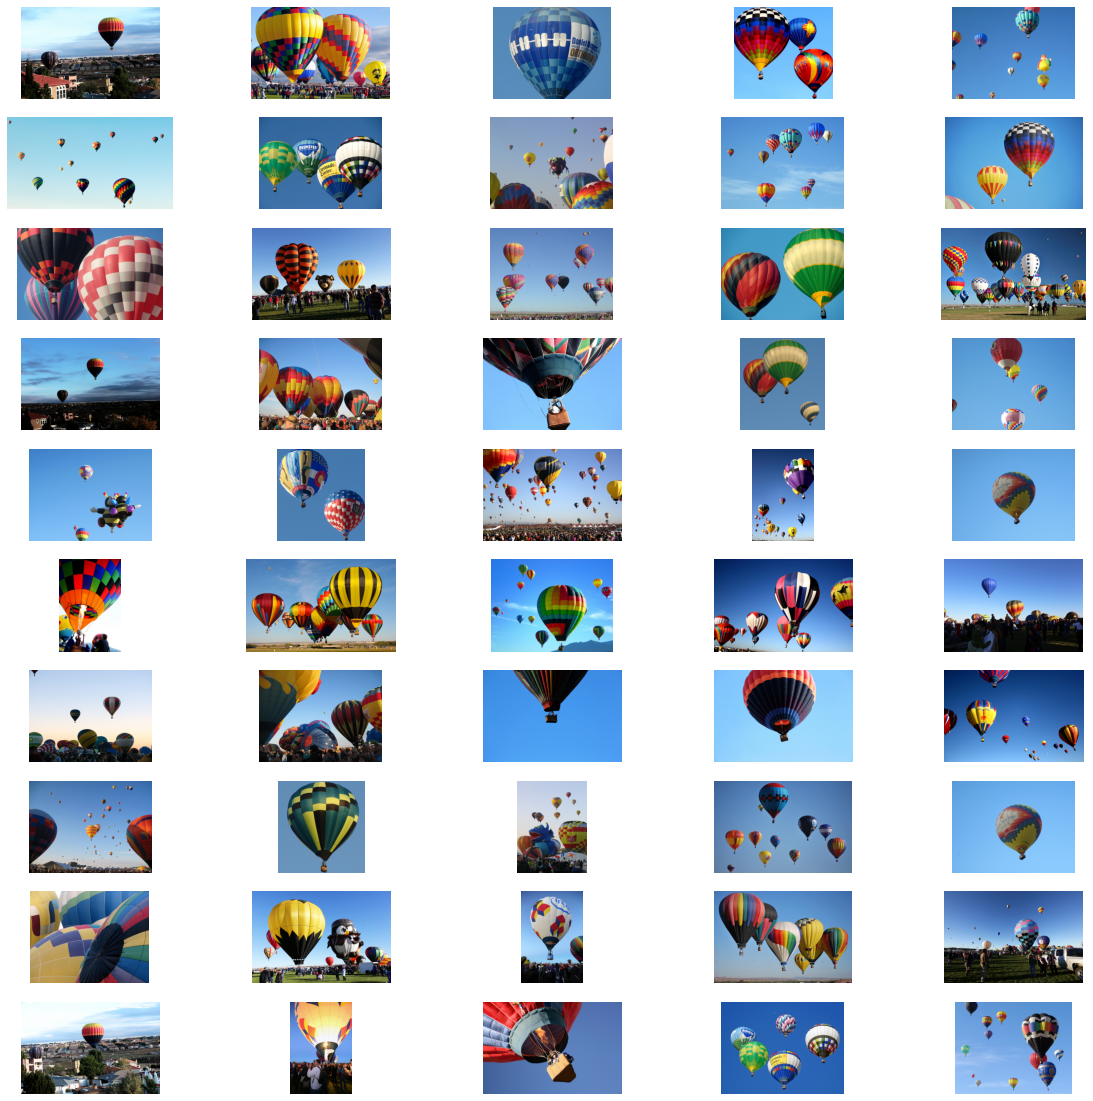

In [379]:
visualize(directorio,topic,ranking_final)

In [276]:
#fig,ax = plt.subplots(10,5,figsize=(20,20))
#for i,ax in enumerate(ax.flat):
#    img = X_test[int(ranking[i,0])].numpy().transpose((1,2,0))
#    img = img/2 + 0.5
#    ax.axis('off')
#    ax.imshow(img)

In [71]:
def get_rGT(topic):
    rGT_path = r"D:\MediaEval2016\Dades\images\gt\rGT"
    rGT_file = os.path.join(rGT_path,topic_2name(topic)+" rGT.txt")
    rGT = pd.read_csv(rGT_file,sep=",",header=None,names=["Id_Imagen","Relevant"])
    return rGT

In [175]:
for tipo in [1,2,3,4]:
    break
    for topic in [x for x in range(1,136) if x != 124]: 
        creation_positives(topic,n=5,tipo=tipo,numero_clusters=25)

In [209]:
elige_carpeta_positivas = 4

num_clusters = 25

carpetas = []
carpetas_raw = ["5primeras_st_no_diversity","5primeras_st_ClusterVisual","5primeras_Flickr_no_diversity","5primeras_Flickr_ClusterVisual"]
for i in range(len(carpetas_raw)):
    carpetas.append(carpetas_raw[i]+f"_{num_clusters}")
    
    
aciertos=[]
for index,carpeta in enumerate(carpetas):
    aux=[]
    #VAMOS A ESTUDIAR CON EL MÉTODO DE 5 PRIMERAS IMÁGENES CUANTAS SON RELEVANTES DE LAS POSITIVAS
    print(index,carpeta)
    for top in [x for x in range(1,136) if x != 124]:
        rGT = get_rGT(top)
        relevantes = 0
        for name in os.listdir(os.path.join(directorio,"positivas",carpeta,f"topic{top}")):
            name = name.replace(".jpg","")
            relevantes +=(rGT[rGT["Id_Imagen"]==int(name)]["Relevant"]).sum()
        #print(f"Topic {top}: [{relevantes}/5]")
        aux.append(relevantes)
    aciertos.append(aux)
    #print(f"\n\nAciertos en devset: {np.sum(aciertos[1:71])}/{5*70}\n")
    #print(f"Aciertos en testset: {np.sum(aciertos[71:])}/{5*(135-70-1)}\n")
    #print(f"Aciertos en TOTAL: {np.sum(aciertos)}/{5*134}\n\n")
    #print(f"Distribución en devset: {np.unique(aciertos[1:71],return_counts=True)}\n")
    #print(f"Distribución en testset: {np.unique(aciertos[71:],return_counts=True)}\n")
    #print(f"Distribución en TOTAL: {np.unique(aciertos,return_counts=True)}")

0 5primeras_st_no_diversity_25
1 5primeras_st_ClusterVisual_25
2 5primeras_Flickr_no_diversity_25
3 5primeras_Flickr_ClusterVisual_25


Con esto comprobamos que seleccionar las primeras 5 imágenes según el score textual no es una buena idea

In [210]:
for rel in range(6):
    print(aciertos[1].count(rel))

7
14
21
26
23
43


In [142]:
len(aciertos[0][70:])

64